In [40]:
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from openml.tasks import TaskType
import os
from collections import Counter
from sklearn.preprocessing import LabelEncoder
api_key = 'c0d6200b271e73a8aec0904980876c3c'

In [6]:
benchmark_suite = openml.study.get_suite(225)


In [16]:
print(benchmark_suite.name)
print(f'There are {len(dir(benchmark_suite))} attributes')

OpenML100-friendly
There are 58 attributes


In [31]:
print(dir(benchmark_suite))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_apply_repr_template', '_entity_letter', '_get_file_elements', '_get_repr_body_fields', '_parse_publish_response', '_to_dict', '_to_xml', 'alias', 'benchmark_suite', 'creation_date', 'creator', 'data', 'description', 'flows', 'id', 'main_entity_type', 'name', 'open_in_browser', 'openml_url', 'publish', 'push_tag', 'remove_tag', 'runs', 'setups', 'status', 'study_id', 'tags', 'tasks', 'url_for_id']


In [33]:
dataset_info = []

for task_id in tqdm(benchmark_suite.tasks, desc="Collecting dataset info"):
    try:
        task = openml.tasks.get_task(task_id)
        dataset = task.get_dataset()
        qualities = dataset.qualities
        features = dataset.features

        # Count numeric and categorical features
        feature_types = [feat.data_type for feat in features.values() if feat.name != dataset.default_target_attribute]
        n_numeric = feature_types.count('numeric')
        n_categorical = feature_types.count('nominal')

        dataset_info.append({
            'task_id': task_id,
            'dataset_id': dataset.dataset_id,
            'dataset_name': dataset.name,
            'target': task.target_name,
            'task_type': TaskType(task.task_type_id).name,  # ✅ Fixed line
            'url': f"https://www.openml.org/d/{dataset.dataset_id}",
            'has_missing_values': qualities.get('NumberOfMissingValues', 0) > 0,
            'n_classes': qualities.get('NumberOfClasses'),
            'n_features': qualities.get('NumberOfFeatures'),
            'n_instances': qualities.get('NumberOfInstances'),
            'n_numeric_features': n_numeric,
            'n_categorical_features': n_categorical
        })

    except Exception as e:
        print(f"Failed to process task {task_id}: {e}")

# Convert to DataFrame
df = pd.DataFrame(dataset_info)
print(df.head())


   task_id  dataset_id    dataset_name target                  task_type  \
0        6           6          letter  class  SUPERVISED_CLASSIFICATION   
1       11          11   balance-scale  class  SUPERVISED_CLASSIFICATION   
2       12          12   mfeat-factors  class  SUPERVISED_CLASSIFICATION   
3       14          14   mfeat-fourier  class  SUPERVISED_CLASSIFICATION   
4       16          16  mfeat-karhunen  class  SUPERVISED_CLASSIFICATION   

                           url  has_missing_values  n_classes  n_features  \
0   https://www.openml.org/d/6               False       26.0        17.0   
1  https://www.openml.org/d/11               False        3.0         5.0   
2  https://www.openml.org/d/12               False       10.0       217.0   
3  https://www.openml.org/d/14               False       10.0        77.0   
4  https://www.openml.org/d/16               False       10.0        65.0   

   n_instances  n_numeric_features  n_categorical_features  
0      20000.0     

In [28]:

ds = openml.datasets.get_dataset(6)
print(f'This is the {ds.name} dataset')
qualities = ds.qualities

print(qualities.keys())

This is the letter dataset
dict_keys(['AutoCorrelation', 'CfsSubsetEval_DecisionStumpAUC', 'CfsSubsetEval_DecisionStumpErrRate', 'CfsSubsetEval_DecisionStumpKappa', 'CfsSubsetEval_NaiveBayesAUC', 'CfsSubsetEval_NaiveBayesErrRate', 'CfsSubsetEval_NaiveBayesKappa', 'CfsSubsetEval_kNN1NAUC', 'CfsSubsetEval_kNN1NErrRate', 'CfsSubsetEval_kNN1NKappa', 'ClassEntropy', 'DecisionStumpAUC', 'DecisionStumpErrRate', 'DecisionStumpKappa', 'Dimensionality', 'EquivalentNumberOfAtts', 'J48.00001.AUC', 'J48.00001.ErrRate', 'J48.00001.Kappa', 'J48.0001.AUC', 'J48.0001.ErrRate', 'J48.0001.Kappa', 'J48.001.AUC', 'J48.001.ErrRate', 'J48.001.Kappa', 'MajorityClassPercentage', 'MajorityClassSize', 'MaxAttributeEntropy', 'MaxKurtosisOfNumericAtts', 'MaxMeansOfNumericAtts', 'MaxMutualInformation', 'MaxNominalAttDistinctValues', 'MaxSkewnessOfNumericAtts', 'MaxStdDevOfNumericAtts', 'MeanAttributeEntropy', 'MeanKurtosisOfNumericAtts', 'MeanMeansOfNumericAtts', 'MeanMutualInformation', 'MeanNoiseToSignalRatio', '

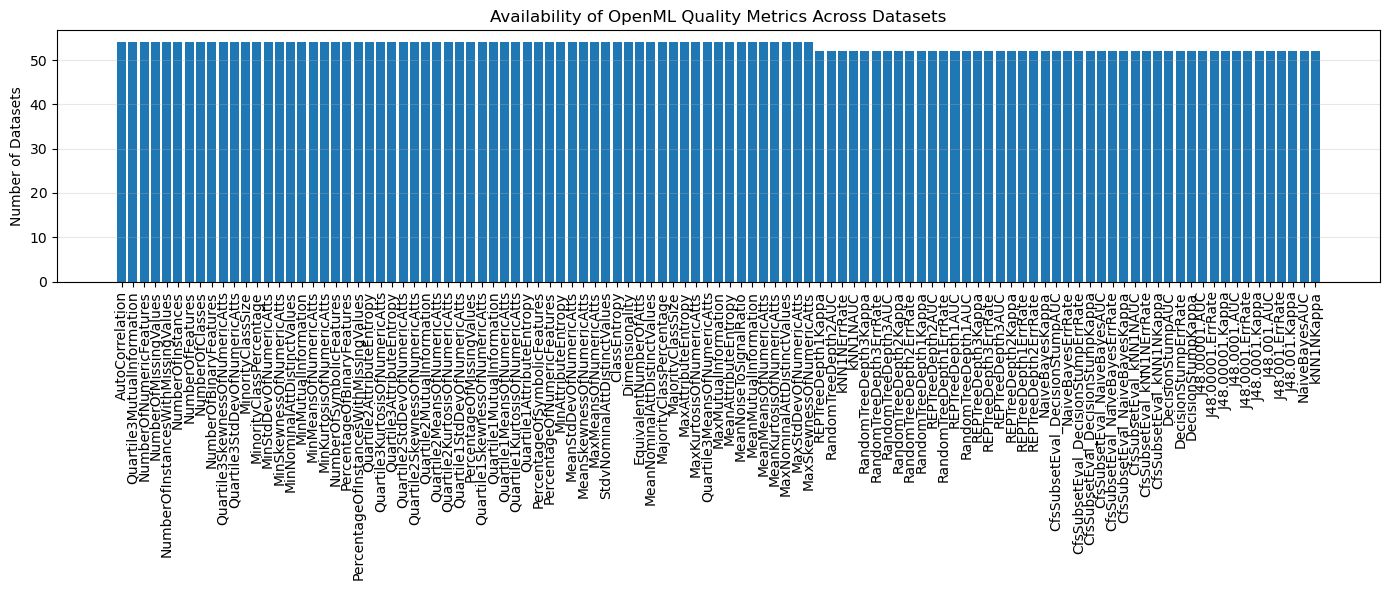

In [36]:
# Initialize quality tracker
quality_counter = Counter()

# Loop through all tasks in the benchmark suite
for task_id in tqdm(benchmark_suite.tasks, desc="Collecting quality keys"):
    try:
        task = openml.tasks.get_task(task_id)
        dataset = task.get_dataset()
        qualities = dataset.qualities
        
        # Count which qualities are present
        quality_counter.update(qualities.keys())

    except Exception as e:
        print(f"Failed to process task {task_id}: {e}")

# Convert to DataFrame for plotting
quality_df = pd.DataFrame(quality_counter.items(), columns=["Quality", "Count"])
quality_df = quality_df.sort_values(by="Count", ascending=False)

# Plot the histogram
plt.figure(figsize=(14, 6))
plt.bar(quality_df["Quality"], quality_df["Count"])
plt.xticks(rotation=90)
plt.ylabel("Number of Datasets")
plt.title("Availability of OpenML Quality Metrics Across Datasets")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Dataset Preparation for Meta-Learning

In this step, we downloaded multiple datasets from the OpenML benchmark suite and stored them in a standardized format for downstream meta-learning tasks.

For each dataset:
- We created a dedicated folder named after the dataset (e.g., `iris`, `credit-g`, etc.).
- We extracted the features (X) and target labels (y) using OpenML's API.
- We saved the features as `{dataset_name}_py.dat` — a plain text file containing the feature matrix **without headers** or indices.
- We saved the target labels separately as `labels_py.dat` — also a plain text file **without headers**.

All datasets are stored under the top-level `test_datasets/` directory, preserving consistent structure for reproducibility and easy loading during training and evaluation.

This format is particularly suitable for methods that expect raw `.dat` inputs for features and labels.


In [42]:
os.makedirs("test_datasets", exist_ok=True)

# Iterate through your DataFrame (assuming 'df' is already defined)
for _, row in tqdm(df.iterrows(), total=len(df), desc="Downloading datasets"):
    dataset_id = row['dataset_id']
    dataset_name = row['dataset_name']
    target = row['target']

    try:
        # Download dataset
        dataset = openml.datasets.get_dataset(dataset_id)
        X, y, _, _ = dataset.get_data(target=target)

        # Create subdirectory
        folder_path = os.path.join("test_datasets", dataset_name)
        os.makedirs(folder_path, exist_ok=True)

        # Save X (features) to {dataset_name}_py.dat
        x_path = os.path.join(folder_path, f"{dataset_name}_py.dat")
        np.savetxt(x_path, X.values, fmt="%s", delimiter=",")

        # Save y (labels) to labels_py.dat
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Save encoded y
        y_path = os.path.join(folder_path, "labels_py.dat")
        np.savetxt(y_path, y_encoded, fmt="%d")

    except Exception as e:
        print(f"Failed to download dataset {dataset_name} (ID: {dataset_id}): {e}")
